# Data prep for Tglang

Read files from folders and create a csv train set and a csv test.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Data configs

In [3]:
THESTACK = ["./data/raw/thestack_v2/", "./data/raw/thestack_v3/"]
TEST = "./data/raw/tg-r1-test/"
TEST_OTHER = "./data/raw/ml2023-r1-dataset/"

TRAIN_OTHER_RATIO = 0.2
TEST_OTHER_RATIO = 1.0

LINES = (10, 25)
MAX_CHARS = 4096

FILTER_CODE_OTHER = True

In [4]:
SAVE_TRAIN = "./data/processed/tglang_train.csv"
SAVE_TEST = "./data/processed/tglang_test.csv"
SAVE_SPE_DATA = "./data/processed/tglang_spe.txt"

## Load data

In [5]:
def extract_text_blocks(file, augment=True):
    """Read text file and split into groups of lines"""
    text = file.read_text().strip()[:MAX_CHARS]
    lines = re.split("\n+", text)
    n = 0
    blocks = []
    if augment:
        while n < len(lines):
            n_lines = random.randint(LINES[0], LINES[1])
            blocks.append(lines[n: n+n_lines])
            n += n_lines
    else:
        blocks.append(lines)
    return blocks


def load_dataset(files, blocks=True):
    """Load a dataset with augmentation"""
    data = []
    for f in files:
        try:
            blocks = extract_text_blocks(f, augment=blocks)
            for block in blocks:
                n_lines = len(block)
                content = "\n".join(block)
                data.append((content, f.parent.name.strip(), len(content), n_lines, str(f)))
        except UnicodeDecodeError as e:
            print(f"Unable to read {f!r}", e)

    data = pd.DataFrame(data, columns=["content", "lang", "num_chars", "num_lines", "file"])
    return data




def get_files(folder, filter_other):
    """Get a list of filtered list of flies"""
    files = Path(folder).rglob("*.*")

    files = filter(lambda x: bool(x.suffix), files)
    files = filter(lambda x: x.parent.name.strip() in LANG_ENUM, files)
    if filter_other:
        files = filter(lambda x: x.parent.name.strip() != LANG_ENUM[0], files)

    return list(files)

### Lang enum

In [6]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().split()
LANG_ENUM = [l.strip() for l in LANG_ENUM]

len(LANG_ENUM)

29

### Train set

In [7]:
files = sum([get_files(one, FILTER_CODE_OTHER) for one in THESTACK], [])

len(files)

3718

In [8]:
thestack = load_dataset(files)
thestack.sample(5)

,content,lang,num_chars,num_lines,file
5852,\t&& ln -s /opt/yarn/bin/yarn /usr/local/bin/y...,TGLANG_LANGUAGE_DOCKER,720,11,data/raw/thestack_v2/ TGLANG_LANGUAGE_DOCKER/...
12327,"const CHFL_TOPOLOGY* topology, uint64_t i\...",TGLANG_LANGUAGE_C,443,11,data/raw/thestack_v2/TGLANG_LANGUAGE_C/40.txt
1140,import org.slf4j.Logger;\nimport org.slf4j.Log...,TGLANG_LANGUAGE_JAVA,739,15,data/raw/thestack_v2/ TGLANG_LANGUAGE_JAVA/64...
3306,"members: data.members,\n publishedA...",TGLANG_LANGUAGE_TYPESCRIPT,409,14,data/raw/thestack_v2/ TGLANG_LANGUAGE_TYPESCR...
11690,[self.baseViewController dismissViewControll...,TGLANG_LANGUAGE_OBJECTIVE_C,84,3,data/raw/thestack_v2/ TGLANG_LANGUAGE_OBJECTI...


In [9]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14905 entries, 0 to 14904
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    14905 non-null  object
 1   lang       14905 non-null  object
 2   num_chars  14905 non-null  int64 
 3   num_lines  14905 non-null  int64 
 4   file       14905 non-null  object
dtypes: int64(2), object(3)
memory usage: 582.4+ KB


#### Missing languages

In [10]:
diff_langs = set(LANG_ENUM).difference(thestack["lang"].unique())

print("Number of languages missing", len(diff_langs))

Number of languages missing 1


In [11]:
pprint(diff_langs)


{'TGLANG_LANGUAGE_OTHER'}


#### Filter Empty

In [12]:
empty = thestack.loc[(thestack["content"] == "") | (thestack["num_chars"] == 0)]

empty.shape


(1, 5)

In [13]:
thestack = thestack.loc[(thestack["content"] != "") & (thestack["num_chars"] > 2)]

thestack.shape

(14838, 5)

#### EDA

In [14]:
thestack["num_lines"].sum()

225991

In [15]:
from src.train.plot_utils import barplots

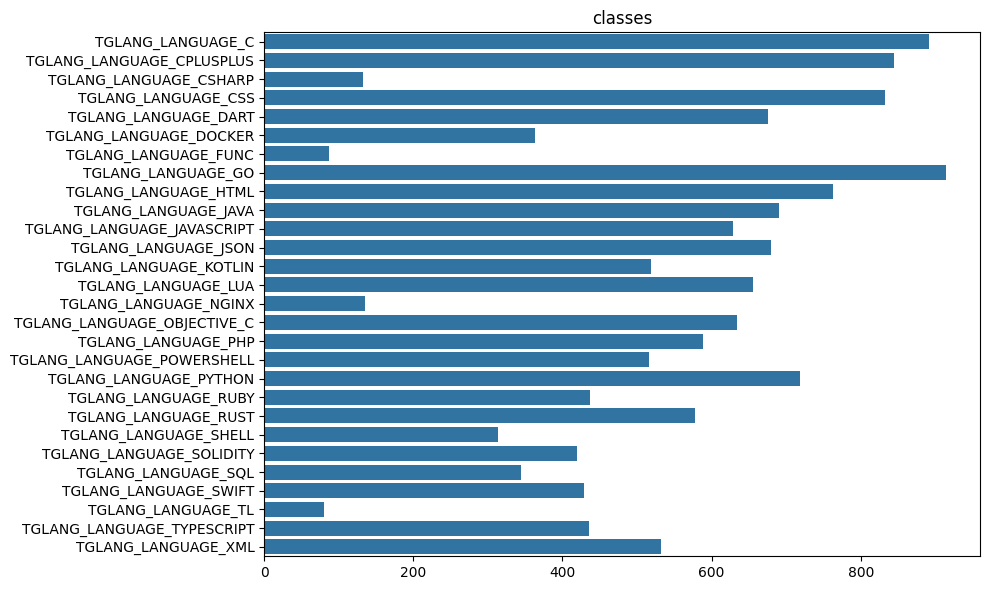

In [16]:
barplots({
    'classes': thestack['lang']
}, 1, 1, horizontal=True, fig_dims=(10, 6))

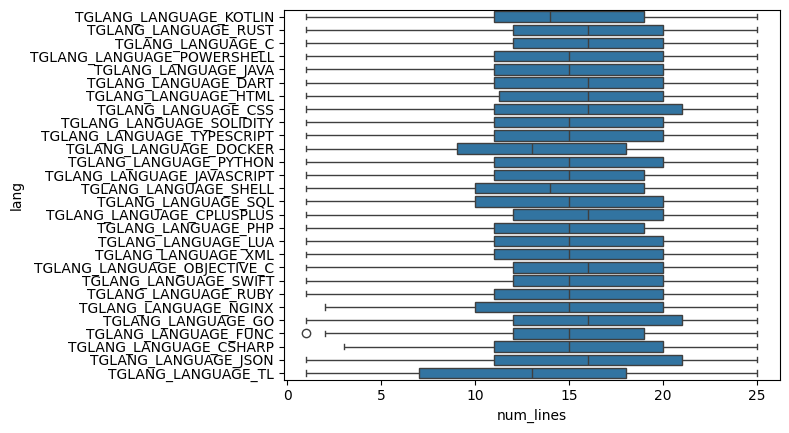

In [17]:
sns.boxplot(x=thestack["num_lines"], y=thestack["lang"]);

### Test set

In [18]:
def load_test_set(files):
    data = []
    for f in files:
        content = f.read_text().strip()
        n_lines = len(content.split('\n'))
        data.append((content, f.parent.name.strip(), len(content), n_lines, str(f)))

    data = pd.DataFrame(data, columns=["content", "lang", "num_chars", "num_lines", "file"])
    return data


In [19]:
test_files = get_files(TEST, FILTER_CODE_OTHER)

len(test_files)

493

In [20]:
test_set = load_test_set(test_files)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    493 non-null    object
 1   lang       493 non-null    object
 2   num_chars  493 non-null    int64 
 3   num_lines  493 non-null    int64 
 4   file       493 non-null    object
dtypes: int64(2), object(3)
memory usage: 19.4+ KB


#### EDA

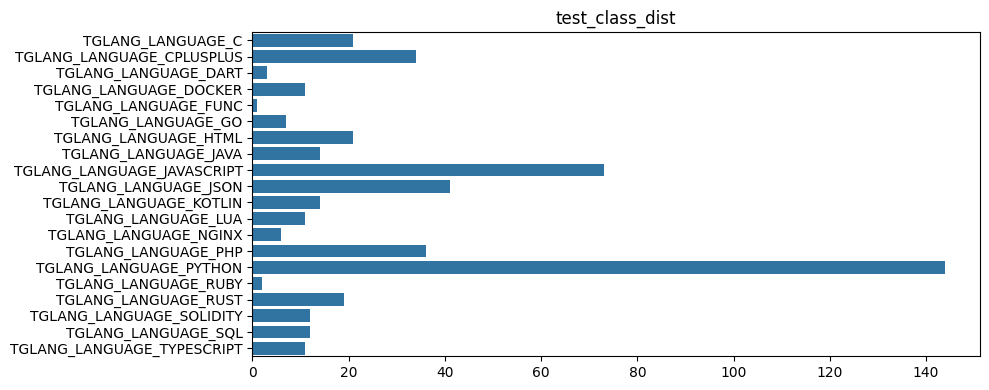

In [21]:
barplots({"test_class_dist": test_set["lang"]}, n_col=1, n_row=1, fig_dims=(10,4))

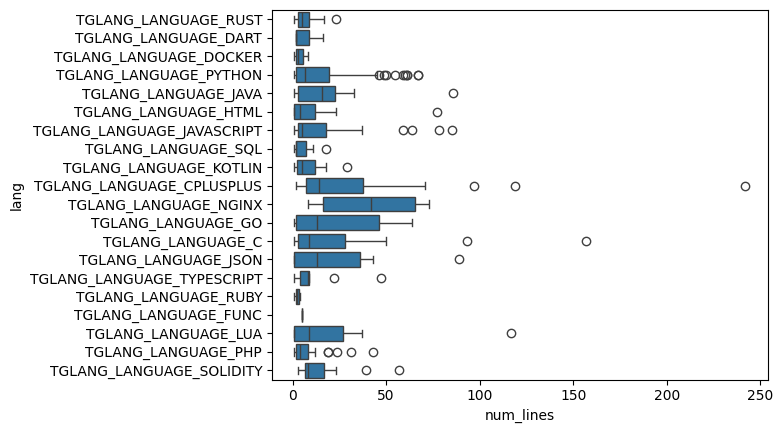

In [22]:
sns.boxplot(y=test_set["lang"], x=test_set["num_lines"]);

In [23]:
test_set["num_lines"].sum()

7404

### OTHER class

#### test set 

In [24]:
test_other_files = list(Path(TEST_OTHER).rglob("*OTHER.txt"))
test_other_num = int(test_set.shape[0] * TEST_OTHER_RATIO)
test_other_selected = random.choices(test_other_files, k=test_other_num)

test_other = load_test_set(test_other_selected)
test_other["lang"] = "TGLANG_LANGUAGE_OTHER"

test_set = pd.concat([test_set,test_other])

In [25]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 0 to 492
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    986 non-null    object
 1   lang       986 non-null    object
 2   num_chars  986 non-null    int64 
 3   num_lines  986 non-null    int64 
 4   file       986 non-null    object
dtypes: int64(2), object(3)
memory usage: 46.2+ KB


In [26]:
test_set["lang"].value_counts(True)

lang
TGLANG_LANGUAGE_OTHER         0.500000
TGLANG_LANGUAGE_PYTHON        0.146045
TGLANG_LANGUAGE_JAVASCRIPT    0.074037
TGLANG_LANGUAGE_JSON          0.041582
TGLANG_LANGUAGE_PHP           0.036511
TGLANG_LANGUAGE_CPLUSPLUS     0.034483
TGLANG_LANGUAGE_HTML          0.021298
TGLANG_LANGUAGE_C             0.021298
TGLANG_LANGUAGE_RUST          0.019270
TGLANG_LANGUAGE_KOTLIN        0.014199
TGLANG_LANGUAGE_JAVA          0.014199
TGLANG_LANGUAGE_SQL           0.012170
TGLANG_LANGUAGE_SOLIDITY      0.012170
TGLANG_LANGUAGE_TYPESCRIPT    0.011156
TGLANG_LANGUAGE_LUA           0.011156
TGLANG_LANGUAGE_DOCKER        0.011156
TGLANG_LANGUAGE_GO            0.007099
TGLANG_LANGUAGE_NGINX         0.006085
TGLANG_LANGUAGE_DART          0.003043
TGLANG_LANGUAGE_RUBY          0.002028
TGLANG_LANGUAGE_FUNC          0.001014
Name: proportion, dtype: float64

#### Add other to train

In [27]:
train_other_num = int(thestack.shape[0] * TRAIN_OTHER_RATIO)
train_other_selected = random.choices(test_other_files, k=train_other_num)
train_other = load_dataset(train_other_selected, blocks=True)
train_other["lang"] = "TGLANG_LANGUAGE_OTHER"
thestack = pd.concat([thestack, train_other])

In [28]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17948 entries, 0 to 3109
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    17948 non-null  object
 1   lang       17948 non-null  object
 2   num_chars  17948 non-null  int64 
 3   num_lines  17948 non-null  int64 
 4   file       17948 non-null  object
dtypes: int64(2), object(3)
memory usage: 841.3+ KB


In [29]:
thestack["lang"].value_counts(True)

lang
TGLANG_LANGUAGE_OTHER          0.173278
TGLANG_LANGUAGE_GO             0.050925
TGLANG_LANGUAGE_C              0.049699
TGLANG_LANGUAGE_CPLUSPLUS      0.047080
TGLANG_LANGUAGE_CSS            0.046412
TGLANG_LANGUAGE_HTML           0.042456
TGLANG_LANGUAGE_PYTHON         0.040060
TGLANG_LANGUAGE_JAVA           0.038444
TGLANG_LANGUAGE_JSON           0.037887
TGLANG_LANGUAGE_DART           0.037664
TGLANG_LANGUAGE_LUA            0.036494
TGLANG_LANGUAGE_OBJECTIVE_C    0.035324
TGLANG_LANGUAGE_JAVASCRIPT     0.035046
TGLANG_LANGUAGE_PHP            0.032817
TGLANG_LANGUAGE_RUST           0.032148
TGLANG_LANGUAGE_XML            0.029641
TGLANG_LANGUAGE_KOTLIN         0.028917
TGLANG_LANGUAGE_POWERSHELL     0.028750
TGLANG_LANGUAGE_RUBY           0.024348
TGLANG_LANGUAGE_TYPESCRIPT     0.024292
TGLANG_LANGUAGE_SWIFT          0.023902
TGLANG_LANGUAGE_SOLIDITY       0.023345
TGLANG_LANGUAGE_DOCKER         0.020225
TGLANG_LANGUAGE_SQL            0.019222
TGLANG_LANGUAGE_SHELL          0.01

## From Yonah

## Save

### CSV

In [30]:
thestack.to_csv(SAVE_TRAIN, index=False)

test_set.to_csv(SAVE_TEST, index=False)

### Sentence-piece

In [31]:
write_file = Path(SAVE_SPE_DATA)
if write_file.exists():
    write_file.unlink()

with open(SAVE_SPE_DATA, mode="a") as f:
    for one in tqdm(files):
        f.write(one.read_text())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3718/3718 [00:00<00:00, 13026.78it/s]


In [32]:
!du -hs ./data/processed/*

 40M	./data/processed/tglang_spe.txt
452K	./data/processed/tglang_test.csv
 72K	./data/processed/tglang_test_sample.csv
 11M	./data/processed/tglang_train.csv
3.6M	./data/processed/tglang_train_sample.csv
